In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Change to the shared ECE5554 Computer Vision Final Project Folder.
import os
os.chdir('/content/drive/MyDrive/')

In [ ]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import random

In [ ]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 4
learning_rate = 0.001

In [ ]:
def convert_to_img(path, label):
    # Make list of file names.
    filelist = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    filelist = [i for i in filelist if i is not None]
    
    # Select half of the images at random.
    print("filelist: ", filelist)
    len_half_filelist = len(filelist)//4
    # len_half_filelist = len(filelist)
    print("len_half_filelist: ", len_half_filelist)
    half_filelist = []
    count = 0
    while (count < len_half_filelist): 
      half_filelist.append(random.choice(filelist))
      count+=1

    labels = []
    if label == 'normal':
      labels = [0 for _ in range(len(half_filelist))]
    elif label == 'opaque':
      labels = [1 for _ in range(len(half_filelist))]
    print("labels: ", labels)

    new_img = []
    for file in half_filelist: 
      # reading the image
      image_path = path + "/" +  file
      print("image_path: ", image_path)
      img = imread(image_path, as_gray=True)
      # print("img: ", img)
      #print(type(img))
      if type(img) != None: 
        #img =  subsample1(img)
        if(len(img.shape)<3):
            print('Gray')
        elif (len(img.shape)==3):
          print('Color(RGB)')
        else:
          print('others')
        img = resize(img, (28, 28))
        # print("Height of img: ", len(img))
        # print("Width of img: ", len(img[0]))
        # normalizing the pixel values
        img = img/255.0
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # appending the image into the list
        new_img.append(img)
    
    return new_img, labels

filelist:  ['NORMAL2-IM-0551-0001.jpeg', 'NORMAL2-IM-0552-0001.jpeg', 'NORMAL2-IM-0553-0001.jpeg', 'NORMAL2-IM-0554-0001.jpeg', 'NORMAL2-IM-0555-0001-0001.jpeg', 'NORMAL2-IM-0555-0001-0002.jpeg', 'NORMAL2-IM-0555-0001.jpeg', 'NORMAL2-IM-0557-0001.jpeg', 'NORMAL2-IM-0558-0001.jpeg', 'NORMAL2-IM-0559-0001.jpeg', 'NORMAL2-IM-0561-0001.jpeg', 'NORMAL2-IM-0563-0001.jpeg', 'NORMAL2-IM-0564-0001.jpeg', 'NORMAL2-IM-0566-0001.jpeg', 'NORMAL2-IM-0567-0001.jpeg', 'NORMAL2-IM-0568-0001.jpeg', 'NORMAL2-IM-0569-0001.jpeg', 'NORMAL2-IM-0571-0001.jpeg', 'NORMAL2-IM-0572-0001.jpeg', 'NORMAL2-IM-0573-0001.jpeg', 'NORMAL2-IM-0575-0001.jpeg', 'NORMAL2-IM-0576-0001.jpeg', 'NORMAL2-IM-0577-0001.jpeg', 'NORMAL2-IM-0578-0001.jpeg', 'NORMAL2-IM-0580-0001.jpeg', 'NORMAL2-IM-0579-0001.jpeg', 'NORMAL2-IM-0582-0001.jpeg', 'NORMAL2-IM-0583-0001.jpeg', 'NORMAL2-IM-0585-0001.jpeg', 'NORMAL2-IM-0587-0001.jpeg', 'NORMAL2-IM-0587-0001-0001.jpeg', 'NORMAL2-IM-0587-0001-0002.jpeg', 'NORMAL2-IM-0589-0001.jpeg', 'NORMAL2-IM

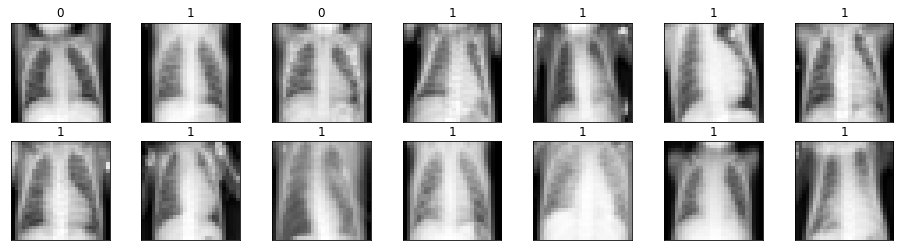

In [ ]:
#! pip install -q kaggle
#from google.colab import files
#files.upload()
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

#import zipfile

#zf = "pneumonia-xray-images.zip"
#target_dir = "content/drive/My Drive"
#zfile = zipfile.ZipFile(zf)
#zfile.extractall(target_dir)

#print("uploaded_data: ", uploaded_data)
#print(type(uploaded_data))
#print(uploaded_data.keys())
#print(uploaded_data.values())

train_normal_path = 'content/drive/My Drive/train/normal'
train_dataset_normal, train_labels_normal = convert_to_img(train_normal_path, "normal")
train_opaque_path = 'content/drive/My Drive/train/opacity'
train_dataset_opaque, train_labels_opaque = convert_to_img(train_opaque_path, "opaque")
train_x = train_dataset_normal + train_dataset_opaque
train_x = np.array(train_x)
# print("train_x: ", train_x)
train_y = train_labels_normal + train_labels_opaque
train_y = np.array(train_y)
train_x.shape

val_normal_path = 'content/drive/My Drive/val/normal'
val_dataset_normal, val_labels_normal = convert_to_img(val_normal_path, 'normal')
val_opaque_path = 'content/drive/My Drive/val/opacity'
val_dataset_opaque, val_labels_opaque = convert_to_img(val_opaque_path, 'opaque')
val_x = val_dataset_normal + val_dataset_opaque
val_x = np.array(val_x)
val_x.shape
val_y = val_labels_normal + val_labels_opaque
val_y = np.array(val_y)

fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(train_x), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(train_y[indices[counter]])
        axes[i,j].imshow(train_x[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
# converting training images into torch format
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[2])
print("train_x.shape[0]: ",train_x.shape[0])
print("train_x.shape[1]: ",train_x.shape[1])
print("train_x.shape[2]: ",train_x.shape[2])
train_x = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape
print("train_x.shape: ", train_x.shape)
print("train_y.shape: ", train_y.shape)

# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, val_x.shape[1], val_x.shape[2])
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape
print("val_x.shape: ", val_x.shape)
print("val_y.shape: ", val_x.shape)

train_x.shape[0]:  1047
train_x.shape[1]:  1
train_x.shape[2]:  28
train_x.shape:  torch.Size([1047, 1, 28, 28])
train_y.shape:  torch.Size([1047])
val_x.shape:  torch.Size([259, 1, 28, 28])
val_y.shape:  torch.Size([259, 1, 28, 28])


In [ ]:
# Creating a CNN class
class ConvNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        print("out: ", out)
        out = self.max_pool1(out)
        print("out: ", out)

        
        out = self.conv_layer2(out)
        print("out: ", out)
        out = self.max_pool2(out)
        print("out: ", out)

                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
# defining the model
model = ConvNet()
#i= 1
#for parameter in model.parameters():
#    print("i = ", i)
#    i+=1
#    print(parameter)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
print("optimizer: ", optimizer)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)
train_losses = []
val_losses = []


optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.07
    maximize: False
    weight_decay: 0
)
ConvNet(
  (conv_layer1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    print("x_train: ", x_train)
    print("y_train: ", y_train)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    #print("x_val: ", x_train)
    #print("y_val: ", y_train)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        #y_train = y_train.type(torch.LongTensor)
        x_val = x_val.cuda()
        y_val = y_val.cuda()
        #y_val = y_val.type(torch.LongTensor)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    # print("x_train: ", x_train)
    output_train = model(x_train)
    #output_train = output_train.type(torch.LongTensor)
    output_val = model(x_val)
    #output_val = output_val.type(torch.LongTensor)


    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    


# defining the number of epochs
n_epochs = 4
# training the model
for epoch in range(n_epochs):
    # print(epoch)
    train(epoch)

x_train:  tensor([[[[1.0387e-03, 1.4261e-03, 1.8608e-03,  ..., 1.7701e-03,
           1.7658e-03, 1.2550e-03],
          [9.4744e-04, 1.3063e-03, 1.8454e-03,  ..., 1.9119e-03,
           1.7070e-03, 1.2303e-03],
          [9.0734e-04, 1.2764e-03, 1.8454e-03,  ..., 2.0761e-03,
           1.7350e-03, 1.2611e-03],
          ...,
          [0.0000e+00, 3.2021e-04, 1.6307e-03,  ..., 2.1376e-03,
           9.0460e-04, 4.6136e-05],
          [0.0000e+00, 3.5096e-04, 1.6874e-03,  ..., 2.1583e-03,
           9.0460e-04, 4.6136e-05],
          [0.0000e+00, 3.6634e-04, 1.7537e-03,  ..., 2.1382e-03,
           9.1998e-04, 4.6136e-05]]],


        [[[1.4204e-03, 1.4727e-03, 1.5225e-03,  ..., 6.1350e-04,
           8.9055e-04, 9.0570e-04],
          [1.3226e-03, 1.5511e-03, 1.6609e-03,  ..., 1.0517e-03,
           1.3241e-03, 1.4302e-03],
          [9.3300e-04, 1.3984e-03, 1.7070e-03,  ..., 1.4113e-03,
           1.6065e-03, 1.6301e-03],
          ...,
          [2.8121e-04, 1.3973e-03, 1.7638e-03, 

RuntimeError: ignored

In [ ]:
def detach(tensorlist):
    detached_list = []
    for i in range(len(tensorlist)):
        detached_list.append(tensorlist[i].item())
    
    return detached_list

In [ ]:
# plotting the training and validation loss
fig = plt.figure()
train_losses = detach(train_losses)
plt.plot(train_losses, label='Training loss')
val_losses = detach(val_losses)
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()
    
softmax = torch.exp(train_x).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

softmax = torch.exp(val_x).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)


In [ ]:
test_normal_path = 'content/drive/My Drive/test/normal'
test_dataset_normal, test_label_normal = convert_to_img(test_normal_path, "normal")
test_opaque_path = 'content/drive/My Drive/test/opacity'
test_dataset_opaque, test_label_opaque = convert_to_img(test_opaque_path, "opaque")
test_x = test_dataset_normal + test_dataset_opaque
test_x = np.array(test_x)
test_y = test_label_normal + test_label_opaque
test_y = np.array(test_y)

test_x  = torch.from_numpy(test_x)
test_x.shape

# generating predictions for test set
output = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
prob = list(output.numpy())
predictions = np.argmax(prob, axis=1)